### Import all the required modules

In [7]:
import soundfile as sf
import numpy as np
import tensorflow as tf
from tensorflow import keras
from scipy.signal import find_peaks
import matplotlib.pyplot as plt

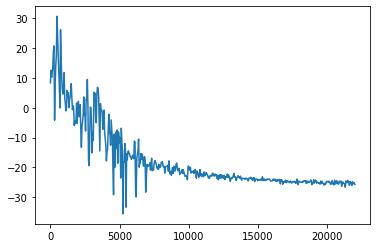

In [10]:
# Read the sound
x, fr = sf.read('/Users/sashi/repos/sms-tools/sounds/violin-B3.wav')

# Choose fft parameters
tinstant = 1 # seconds
fft_size = 1024
window_size = 1024
fft_res =fr/fft_size

mag = np.abs(np.fft.fft(x, n=fft_size))[0:int(fft_size/2)]
freq = np.arange(0, fft_size/2)*fft_res
plt.plot(freq, 20*np.log10(mag))

### Use find_peaks with appropriate distance and prominence arguments to get the harmonic frequencies.

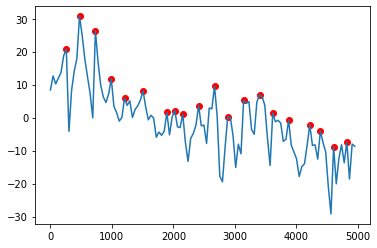

In [102]:
# Find the peaks below 5000Hz
peaks = find_peaks(20*np.log10(mag[0:int(5000/fft_res)]), distance=3, prominence=3)
freq_peaks = peaks[0]*fft_res

# Let's remove the first peak at 42Hz.

plt.plot(freq[0:int(5000/fft_res)], 20*np.log10(mag[0:int(5000/fft_res)]))
plt.scatter(freq_peaks, 20*np.log10(mag[0:int(5000/fft_res)])[peaks[0]], color='r')

### Check to see that the harmonic frequencies fit a straight line

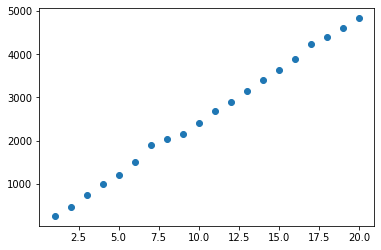

In [103]:
plt.scatter(np.arange(1, len(freq_peaks)+1), np.array(freq_peaks))

### Use a neural network to do linear regression on the harmonic frequencies and the harmonic number.

In the below cell the neural network is not converging when using the harmonic frequencies. So I generated data based on a linear model and ran fit for this model. Even here the neural network did not converge. So it seems that the harmonic frequencies data is not the problem.

Epoch 1/10
1/1 [==============================] - 0s 262ms/step - loss: 8987188.0000
Epoch 2/10
1/1 [==============================] - 0s 5ms/step - loss: 23423492.0000
Epoch 3/10
1/1 [==============================] - 0s 5ms/step - loss: 61096044.0000
Epoch 4/10
1/1 [==============================] - 0s 5ms/step - loss: 159404896.0000
Epoch 5/10
1/1 [==============================] - 0s 6ms/step - loss: 415947616.0000
Epoch 6/10
1/1 [==============================] - 0s 5ms/step - loss: 1085410176.0000
Epoch 7/10
1/1 [==============================] - 0s 5ms/step - loss: 2832409600.0000
Epoch 8/10
1/1 [==============================] - 0s 6ms/step - loss: 7391301120.0000
Epoch 9/10
1/1 [==============================] - 0s 6ms/step - loss: 19287984128.0000
Epoch 10/10
1/1 [==============================] - 0s 6ms/step - loss: 50333040640.0000


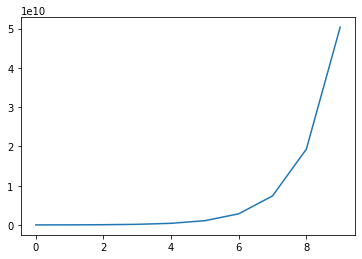

In [128]:
# Fit the neural network to determine the fundamental frequency

# Build a simple Sequential model
model = tf.keras.Sequential([keras.layers.Dense(units=1, input_shape=[1], name='layer1')]
                           )
# Compile the model
model.compile(optimizer='sgd', loss='mean_squared_error')

# Declare model inputs and outputs for training
xs = np.arange(1, len(freq_peaks[1:])+1)
ys = np.array(freq_peaks[1:])
# ys = xs*250 + 10 #Test

mask = np.random.permutation(np.arange(0,len(xs)))
history = model.fit(xs[mask], ys[mask], epochs=10)

plt.plot(history.history['loss'])

Let's use more units in the layer and see what happens

[<tf.Variable 'layer1/kernel:0' shape=(1, 2) dtype=float32, numpy=array([[261.21475, 261.2135 ]], dtype=float32)>, <tf.Variable 'layer1/bias:0' shape=(2,) dtype=float32, numpy=array([23.142258, 23.172873], dtype=float32)>]


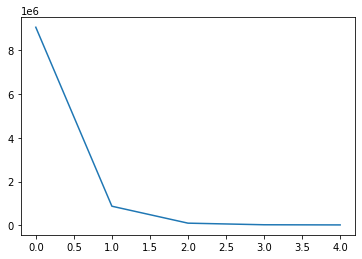

In [144]:
model2 = tf.keras.Sequential([keras.layers.Dense(units=2, input_shape=[1], name='layer1')])

# Compile the model
model2.compile(optimizer='sgd', loss='mean_squared_error')

mask = np.random.permutation(np.arange(0,len(xs)))
history = model2.fit(xs[mask], ys[mask], epochs=5, verbose=0)

plt.plot(history.history['loss'])

print(model2.weights)

### Finding the fundamental frequency

Here we see that the loss has decreased and the model is converging. Now we can find the fundamental frequency by predicting the 1st Harmonic.

In [145]:
model2.predict([1])

1/1 [==============================] - 0s 78ms/step


array([[284.357  , 284.38638]], dtype=float32)

### Summary

Above we see that the fundamental frequency is estimated as 284Hz. But we know that the Violin is playing a B3 note and it's frequency is 246.94Hz. So there is a lot of error in the estimation by our current method. By checking the weights of fitted network we see that both are 261. This is closer to the fundamental frequency.

We used a simple network with 2 units to predict the frequency of harmonics. Based on intuition a network with 1 unit should suffice but it did not converge.

Perhaps there are simpler and more intuitive ways of finding the fundamental frequency of a note.